In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [2]:
import sys

sys.path.append('../../../src')



In [3]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [4]:
np.random.seed(seed = 0)

In [5]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [6]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/20kstd5/
save = False
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 432 µs, sys: 0 ns, total: 432 µs
Wall time: 709 µs


In [11]:
N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.3241]
r_big = [0.3241,0.4583]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085
3,0.437587,0.891773,1,0,-3.197153,6.221109,9.418262
4,0.963663,0.383442,0,0,3.046737,-1.946728,-4.993465


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.495176,0.500139,0.985700,0.502900,0.815789,0.849737,1.013680
std,0.289365,0.289445,0.816412,0.500004,5.036672,5.031502,7.062445
min,0.000072,0.000074,0.000000,0.000000,-23.260588,-19.899624,-29.965137
25%,0.243445,0.248979,0.000000,0.000000,-2.596566,-2.544809,-3.747040
50%,0.495403,0.499194,1.000000,1.000000,0.811079,0.833501,0.968230
75%,0.743434,0.754316,2.000000,1.000000,4.212947,4.244116,5.779003
max,0.999962,0.999978,2.000000,1.000000,19.706992,22.208860,28.781063


In [14]:
data['C'].value_counts()/len(data)

0    0.3405
1    0.3333
2    0.3262
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0    0.093342
1    1.087609
2    1.898825
Name: ITE, dtype: float64

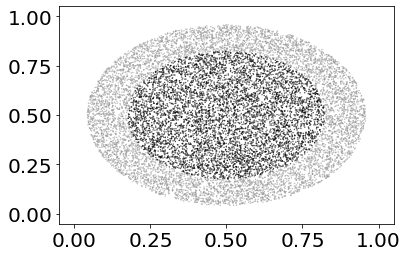

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 24 s, sys: 33.8 ms, total: 24 s
Wall time: 24 s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,0,1.486703,-5.742180
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,0,5.520632,12.854301
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085,0,-5.547478,-1.299706
3,0.437587,0.891773,1,0,-3.197153,6.221109,9.418262,0,-1.280471,1.916682
4,0.963663,0.383442,0,0,3.046737,-1.946728,-4.993465,0,4.545466,1.498729


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.913607  1.077692  1.068755  0.164085  0.155147
            1        0.757222  1.091234  0.823946  0.334012  0.066724
          1 0       -0.199600  0.870944  0.969212  1.070545  1.168812
            1        0.114042  1.256003  1.078528  1.141962  0.964486
          2 0        0.062701  2.125011  2.025568  2.062310  1.962866
            1        0.202696  1.570042  2.219126  1.367345  2.016429
1         0 0        0.935574  0.959958  0.856275 -0.024384  0.079299
            1        1.085869  1.047190  0.703656  0.038678  0.382212
          1 0        1.086057 -0.030674  0.025641  1.116730  1.060416
            1        0.929491 -0.065308 -0.092613  0.994799  1.022104
          2 0        2.036048  0.162544 -0.000742  1.873504  2.036789
            1        1.944375  0.081850  0.089313  1.862524  1.855062

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 17min 2s, sys: 1.71 s, total: 17min 3s
Wall time: 22.9 s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,0,1.486703,-5.742180,83,116
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,0,5.520632,12.854301,61,103
2,0.423655,0.645894,2,0,-4.247772,3.155313,7.403085,0,-5.547478,-1.299706,81,48
3,0.437587,0.891773,1,0,-3.197153,6.221109,9.418262,0,-1.280471,1.916682,103,87
4,0.963663,0.383442,0,0,3.046737,-1.946728,-4.993465,0,4.545466,1.498729,54,20


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.670854,151.0,1.0,0.00755
1,1,0.022980,179.0,1.0,0.00895
2,2,-0.034702,129.0,1.0,0.00645


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


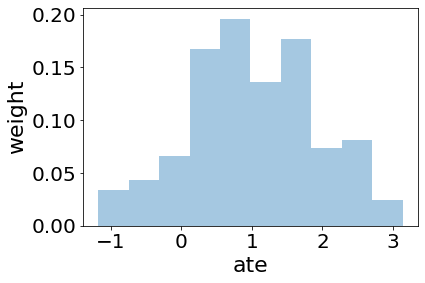

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



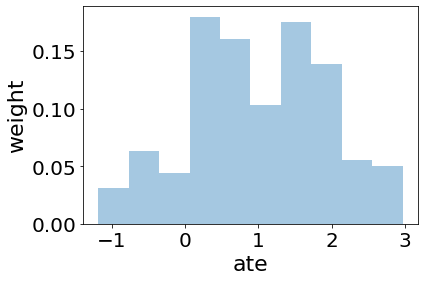

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


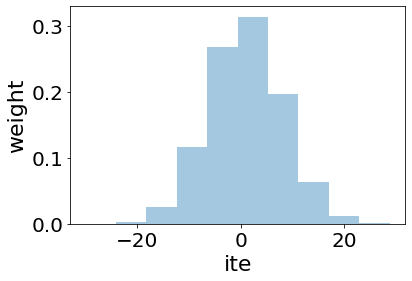

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 10,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,60.000000,1.026115,165.289256,0.881427,0.008264
std,35.073732,0.906545,13.062949,0.180394,0.000653
min,0.000000,-1.178403,129.000000,0.502924,0.006450
25%,30.000000,0.445210,156.000000,0.862857,0.007800
50%,60.000000,0.965248,166.000000,0.994186,0.008300
75%,90.000000,1.689910,175.000000,1.000000,0.008750
max,120.000000,3.136962,206.000000,1.000000,0.010300


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


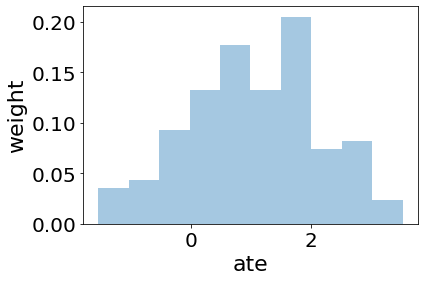

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




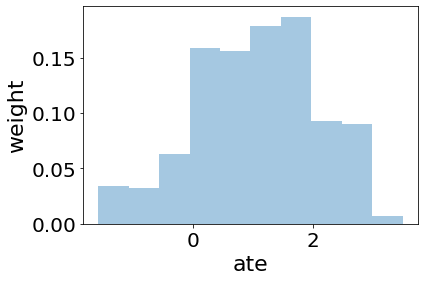

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

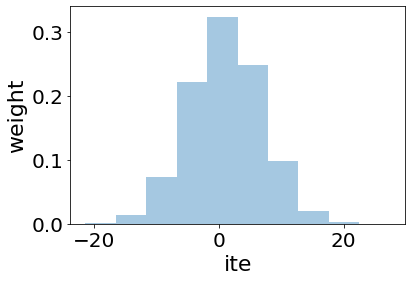

In [32]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})

ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 3
for dd, name, name2,w in zip(all_data, names_to_give, names_to_find,weights):
    kmeans_clustering(dd, clusters = clusts, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 115 ms, sys: 3.97 ms, total: 119 ms
Wall time: 117 ms


In [34]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.670854,151.0,1.0,0.00755,2
1,1,0.022980,179.0,1.0,0.00895,1


In [35]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,0,1.486703,-5.742180,83,116
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,0,5.520632,12.854301,61,103


### 3 Clustering in the ITEs

In [36]:
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [37]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [38]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,2,0,7.228883,0.582488,-6.646395,0,1.486703,-5.742180,83,116,1,2,0,2,1,1
1,0.602763,0.544883,2,0,-7.333669,-6.142980,1.190689,0,5.520632,12.854301,61,103,0,1,0,2,1,1


### Plot reconstruction of data

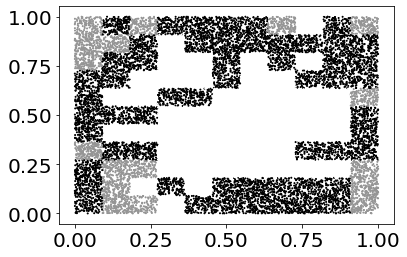

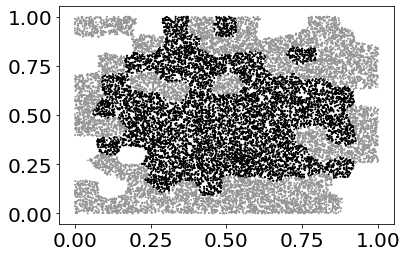

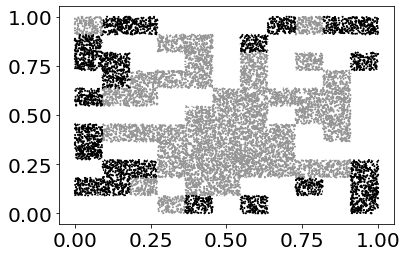

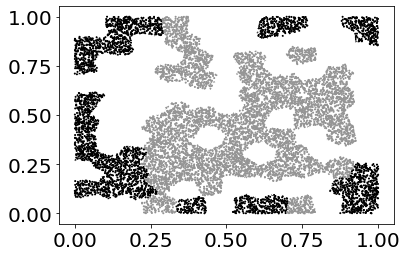

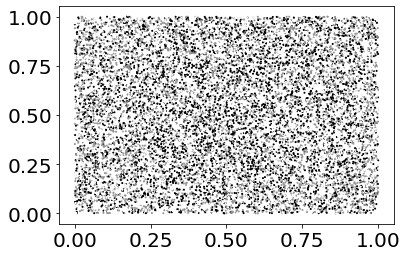

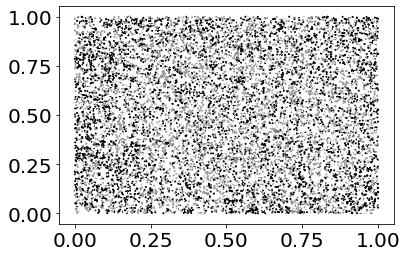

CPU times: user 3.94 s, sys: 49.8 ms, total: 3.99 s
Wall time: 3.95 s


In [39]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:

        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [40]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [41]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [42]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [43]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [44]:
errors.sort_values(by = 'mean')

,mean,std
Kmeans2-Cl2-err-True-ITE,0.500837,0.469542
Box-Cl2-err-True-ITE,0.511943,0.423968
Kmeans-Cl2-err-True-ITE,0.520007,0.351705
Kmeans-Cl2-err-GDBR,0.522946,0.388466
Box2-Cl2-err-True-ITE,0.533836,0.467433
Box-Cl2-err-GDBR,0.540054,0.451818
Kmeans2-Cl2-err-GDBR,0.634623,0.507942
Box2-Cl2-err-GDBR,0.664877,0.516767
ITE-2CTrue-err-GDBR,2.624467,1.930000
ITE-2CGDBR-err-True-ITE,3.104820,2.377274


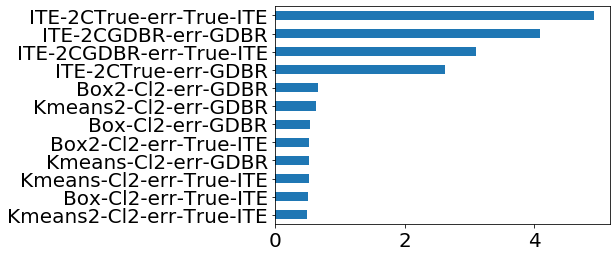

In [45]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()